프로젝트 목표
>최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 보고 결과 비교하기  

추가로 생각해볼 것들   
>augmentation의 의미, 왜 효과가 있는지, 효과가 없는지

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import pandas as pd

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


# 1. Augmentation을 적용한 데이터셋 만들기

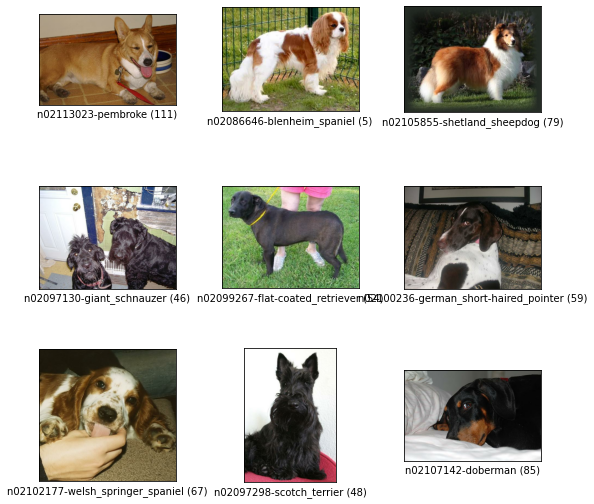

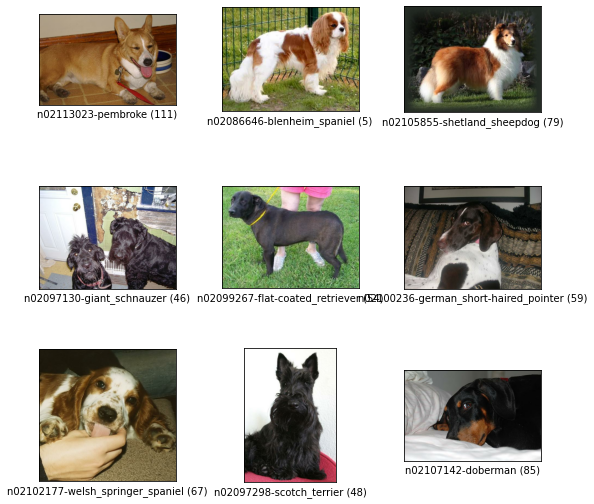

In [3]:
# 데이터 준비하기

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True 
)

tfds.show_examples(ds_train, ds_info)

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# cutmix 함수 정의하기
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [5]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [16]:
# 전처리, 데이터 증강 함수들

num_classes = ds_info.features["label"].num_classes

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

def onehot(image, label):
    label = tf.cast(label, tf.int32)  # Cast label to int32
    label = tf.one_hot(label, depth=num_classes)
    
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, 
                               with_cutmix=False, 
                               with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_mixup:
        ds = ds.map(
            mixup, 
            num_parallel_calls=2
        )
    
    elif not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [50]:
import pandas as pd

# 모델이름에서 히스토리 추출하는 함수
def get_history_from_path(path):
    epoch = []
    loss = []
    accuracy = []
    val_loss = []
    val_accuracy = []

    for i in os.listdir(path):
        if '.h5' in i:
            result = i[4:-3].split('-')

            epoch.append(float(i[:2]))
            loss.append(float(result[0]))
            accuracy.append(float(result[1]))
            val_loss.append(float(result[2]))
            val_accuracy.append(float(result[3]))

    history = pd.DataFrame()
    history['epoch'] = epoch
    history['loss'] = loss
    history['accuracy'] = accuracy
    history['val_loss'] = val_loss
    history['val_accuracy'] = val_accuracy

    history.sort_values(by='epoch', inplace=True)
    
    history.reset_index(inplace=True, drop=True)
    
    return history

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b-', label='train_loss')
    ax1.plot(epochs, val_loss, 'r-', label='val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
    ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

In [9]:
from keras.callbacks import Callback
import os

class SaveModelEveryEpoch(Callback):
    def __init__(self, save_path, first_epoch=1):
        super(SaveModelEveryEpoch, self).__init__()
        self.save_path = save_path  # Path where you want to save the models
        self.first_epoch = first_epoch
        
    def on_epoch_end(self, epoch, logs=None):
        file_name = "{}--{:.4f}-{:.4f}-{:.4f}-{:.4f}.h5".format(self.first_epoch + epoch,
                                                                logs['loss'],
                                                                logs['accuracy'],
                                                                logs['val_loss'],
                                                                logs['val_accuracy'])
        model_save_path = os.path.join(self.save_path, file_name)
        
        self.model.save(model_save_path)
#         print(f'Model saved to {model_save_path}')
        
    def get_config(self):
        config = super(SaveModelEveryEpoch, self).get_config()
        config.update({'save_path': self.save_path, 'first_epoch': self.first_epoch})
        return config

# 2. 모델 만들기

In [15]:
# pretrained 모델 불러오기
num_classes = ds_info.features["label"].num_classes

basic_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 3. 모델 훈련하기

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) # 기본 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # 기본 증강 적용한 데이터셋

In [11]:
ds_valid = apply_normalize_on_dataset(ds_test, is_test=True) # 테스트용 데이터셋

In [ ]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True) # cutmix만 적용한 데이터셋
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True) # cutmix만 적용한 데이터셋

In [17]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True) # cutmix만 적용한 데이터셋
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True) # cutmix만 적용한 데이터셋

In [20]:
# !mkdir models/no_aug

In [22]:
# 아무것도 적용하지 않았을 때

# EPOCH = 20

# save_path = './models/no_aug/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                                save_weights_only=False,
#                                                                monitor='val_accuracy',
#                                                                mode='min',
#                                                                save_best_only=False)

# basic_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# history_basic_resnet50 = basic_resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     callbacks=[model_checkpoint_callback]
# )

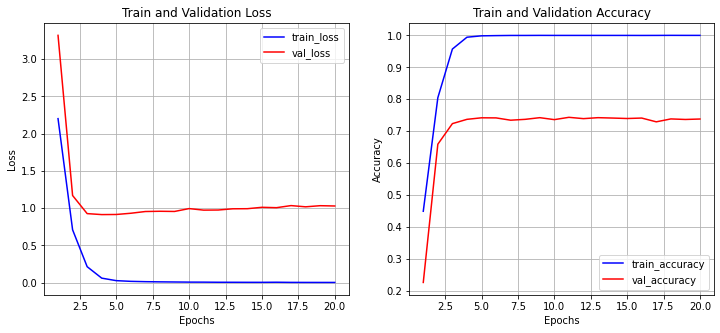

In [34]:
no_aug_history = get_history_from_path('models/no_aug')
plot_history(no_aug_history)

In [37]:
# !mkdir models/aug

In [41]:
# augmentation만 적용했을 때

# EPOCH = 20

# save_path = './models/aug/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                                save_weights_only=False,
#                                                                monitor='val_accuracy',
#                                                                mode='min',
#                                                                save_best_only=False)

# basic_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# history_basic_resnet50 = basic_resnet50.fit(
#     ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     callbacks=[model_checkpoint_callback]
# )

Epoch 1/20
750/750 [==============================] - 165s 206ms/step - loss: 2.2907 - accuracy: 0.4269 - val_loss: 3.3147 - val_accuracy: 0.2274
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.9539 - accuracy: 0.7244 - val_loss: 1.3778 - val_accuracy: 0.6082
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.4813 - accuracy: 0.8698 - val_loss: 1.0709 - val_accuracy: 0.6827
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.3109 - accuracy: 0.9233 - val_loss: 1.0635 - val_accuracy: 0.6961
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1602 - accuracy: 0.9659 - val_loss: 1.0026 - val_accuracy: 0.7151
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0841 - accuracy: 0.9867 - val_loss: 0.9856 - val_accuracy: 0.7252
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0572 - accuracy: 0.9924 - val_loss: 1.0604 -

KeyboardInterrupt: 

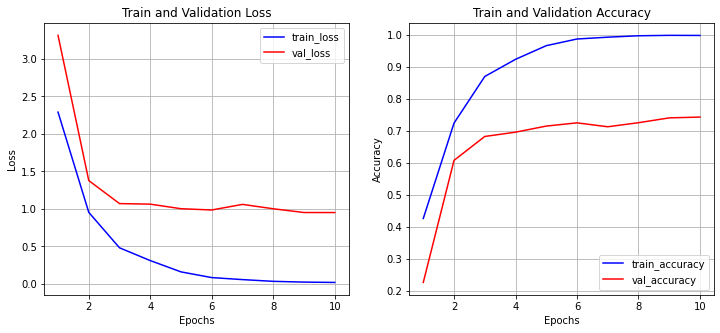

In [42]:
aug_history = get_history_from_path('models/aug')
plot_history(aug_history)

In [30]:
import os

os.listdir('models/aug')

['.ipynb_checkpoints',
 '06--0.0841-0.9867-0.9856-0.7252.h5',
 '02--0.9539-0.7244-1.3778-0.6082.h5',
 '08--0.0341-0.9968-1.0019-0.7256.h5',
 '04--0.3109-0.9233-1.0635-0.6961.h5',
 '07--0.0572-0.9924-1.0604-0.7130.h5',
 '09--0.0239-0.9981-0.9518-0.7407.h5',
 '03--0.4813-0.8698-1.0709-0.6827.h5',
 '05--0.1602-0.9659-1.0026-0.7151.h5',
 '10--0.0193-0.9978-0.9515-0.7432.h5',
 '01--2.2907-0.4269-3.3147-0.2274.h5']

In [31]:
# validation 더 수렴할 수 있을 것 같아서 좀 더 보자
# basic_resnet50 = keras.models.load_model("./models/aug/10--0.0193-0.9978-0.9515-0.7432.h5")

In [34]:
# EPOCH = 10

# basic_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# custom_checkpoint_callback = SaveModelEveryEpoch(save_path='./models/aug', first_epoch=11)

# history_basic_resnet50 = basic_resnet50.fit(
#     ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     callbacks=[custom_checkpoint_callback]
# )

Epoch 1/11
  6/750 [..............................] - ETA: 1:58 - loss: 0.0092 - accuracy: 1.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0751s vs `on_train_batch_end` time: 0.0883s). Check your callbacks.


750/750 [==============================] - 167s 212ms/step - loss: 0.0148 - accuracy: 0.9990 - val_loss: 0.9554 - val_accuracy: 0.7472
Epoch 2/11
750/750 [==============================] - 162s 215ms/step - loss: 0.0124 - accuracy: 0.9992 - val_loss: 0.9618 - val_accuracy: 0.7463
Epoch 3/11
750/750 [==============================] - 163s 217ms/step - loss: 0.0125 - accuracy: 0.9990 - val_loss: 1.2369 - val_accuracy: 0.6953
Epoch 4/11
750/750 [==============================] - 159s 213ms/step - loss: 0.0265 - accuracy: 0.9967 - val_loss: 1.0171 - val_accuracy: 0.7393
Epoch 5/11
750/750 [==============================] - 159s 212ms/step - loss: 0.0106 - accuracy: 0.9996 - val_loss: 0.9895 - val_accuracy: 0.7495
Epoch 6/11
750/750 [==============================] - 173s 231ms/step - loss: 0.0070 - accuracy: 0.9997 - val_loss: 1.0042 - val_accuracy: 0.7414
Epoch 7/11
750/750 [==============================] - 159s 212ms/step - loss: 0.0062 - accuracy: 0.9998 - val_loss: 1.0021 - val_accura

KeyboardInterrupt: 

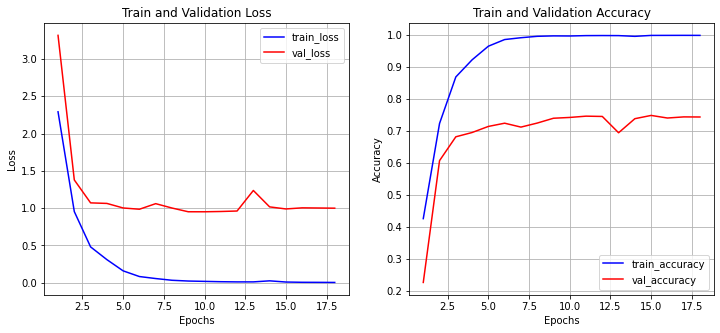

In [35]:
aug_history = get_history_from_path('models/aug')
plot_history(aug_history)

In [8]:
# !mkdir models/cutmix_aug

In [11]:
# cutmix + aug (밝기 변화, flip) 적용한 데이터셋

# EPOCH = 20

# save_path = './models/cutmix_aug/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                                save_weights_only=False,
#                                                                monitor='val_accuracy',
#                                                                mode='min',
#                                                                save_best_only=False)

# cutmix_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# history_cutmix_resnet50 = cutmix_resnet50.fit(
#     ds_train_cutmix_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     callbacks=[model_checkpoint_callback]
# )

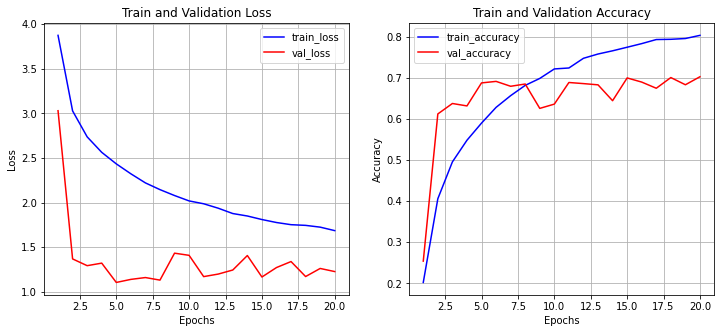

In [35]:
cutmix_aug_history = get_history_from_path('models/cutmix_aug')
plot_history(cutmix_aug_history)

In [17]:
# !mkdir models/cutmix

In [19]:
# with_cutmix 적용한 데이터셋

# EPOCH = 20

# save_path = './models/cutmix/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5'

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
#                                                                save_weights_only=False,
#                                                                monitor='val_accuracy',
#                                                                mode='min',
#                                                                save_best_only=False)

# cutmix_resnet50.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=['accuracy'],
# )

# history_basic_resnet50 = cutmix_resnet50.fit(
#     ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_valid,
#     verbose=1,
#     callbacks=[model_checkpoint_callback]
# )

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.8413 - accuracy: 0.2103 - val_loss: 3.7398 - val_accuracy: 0.1532
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9297 - accuracy: 0.4376 - val_loss: 1.3347 - val_accuracy: 0.6270
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 2.6147 - accuracy: 0.5394 - val_loss: 1.3085 - val_accuracy: 0.6358
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4293 - accuracy: 0.5989 - val_loss: 1.2054 - val_accuracy: 0.6669
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2781 - accuracy: 0.6485 - val_loss: 1.2748 - val_accuracy: 0.6571
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1395 - accuracy: 0.6937 - val_loss: 1.2274 - val_accuracy: 0.6816
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0568 - accuracy: 0.7172 - val_loss: 1.2442 -

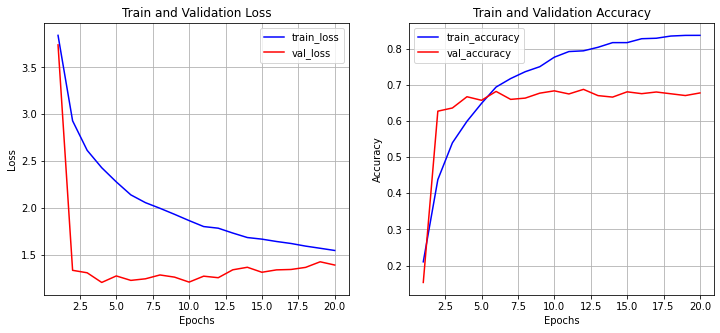

In [36]:
cutmix_history = get_history_from_path('models/cutmix')
plot_history(cutmix_history)

In [36]:
# !mkdir models/mixup

In [19]:
# mixup 적용한 데이터셋

EPOCH = 20

save_path = './models/mixup/{epoch:02d}--{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='min',
                                                               save_best_only=False)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_basic_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
750/750 [==============================] - 209s 206ms/step - loss: 3.7564 - accuracy: 0.2300 - val_loss: 3.9301 - val_accuracy: 0.1195


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.8990 - accuracy: 0.4616 - val_loss: 1.5387 - val_accuracy: 0.5817
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 2.5962 - accuracy: 0.5816 - val_loss: 1.4538 - val_accuracy: 0.5985
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3993 - accuracy: 0.6499 - val_loss: 1.1911 - val_accuracy: 0.6670
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.2831 - accuracy: 0.7014 - val_loss: 1.3179 - val_accuracy: 0.6354
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.1469 - accuracy: 0.7423 - val_loss: 1.2349 - val_accuracy: 0.6638
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0812 - accuracy: 0.7655 - val_loss: 1.2643 - val_accuracy: 0.6597
Epoch 8/20
750/750 [==============================] - 154s 205ms/step - loss: 2.0133 - accuracy: 0.7983 - val_loss: 1.2390 -

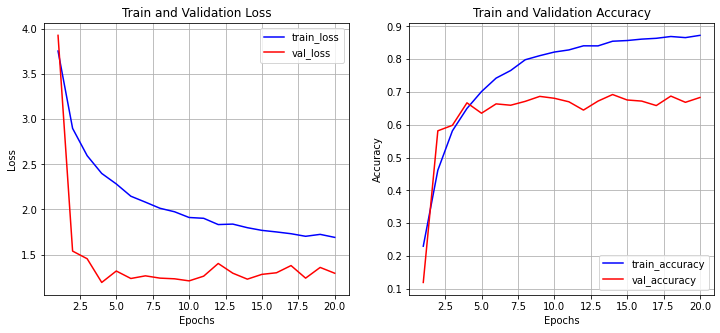

In [20]:
mixup_history = get_history_from_path('models/mixup')
plot_history(mixup_history)

# 4. 훈련 과정 시각화하기 & Augmentation에 의한 모델 성능 비교

In [54]:
no_aug_history = get_history_from_path('models/no_aug')
aug_history = get_history_from_path('models/aug')
cutmix_history = get_history_from_path('models/cutmix')
cutmix_aug_history = get_history_from_path('models/cutmix_aug')
mixup_history = get_history_from_path('models/mixup')

In [60]:
best_results = pd.DataFrame()

total_history = [no_aug_history, aug_history, 
                 cutmix_history, cutmix_aug_history, mixup_history]
conditions = ['no_aug', 'aug', 'cutmix', 'cutmix_aug', 'mixup']

for history in total_history:
    best_results = best_results.append(history.sort_values(by='val_accuracy').iloc[-1])

best_results['condition'] = conditions

In [61]:
best_results.sort_values(by='val_accuracy', ascending=False)

,epoch,loss,accuracy,val_loss,val_accuracy,condition
14,14.0,0.0106,0.9996,0.9895,0.7495,aug
10,11.0,0.0071,0.9998,0.9737,0.7436,no_aug
19,20.0,1.6850,0.8035,1.2258,0.7028,cutmix_aug
13,14.0,1.7981,0.8548,1.2276,0.6923,mixup
11,12.0,1.7842,0.7939,1.2559,0.6873,cutmix


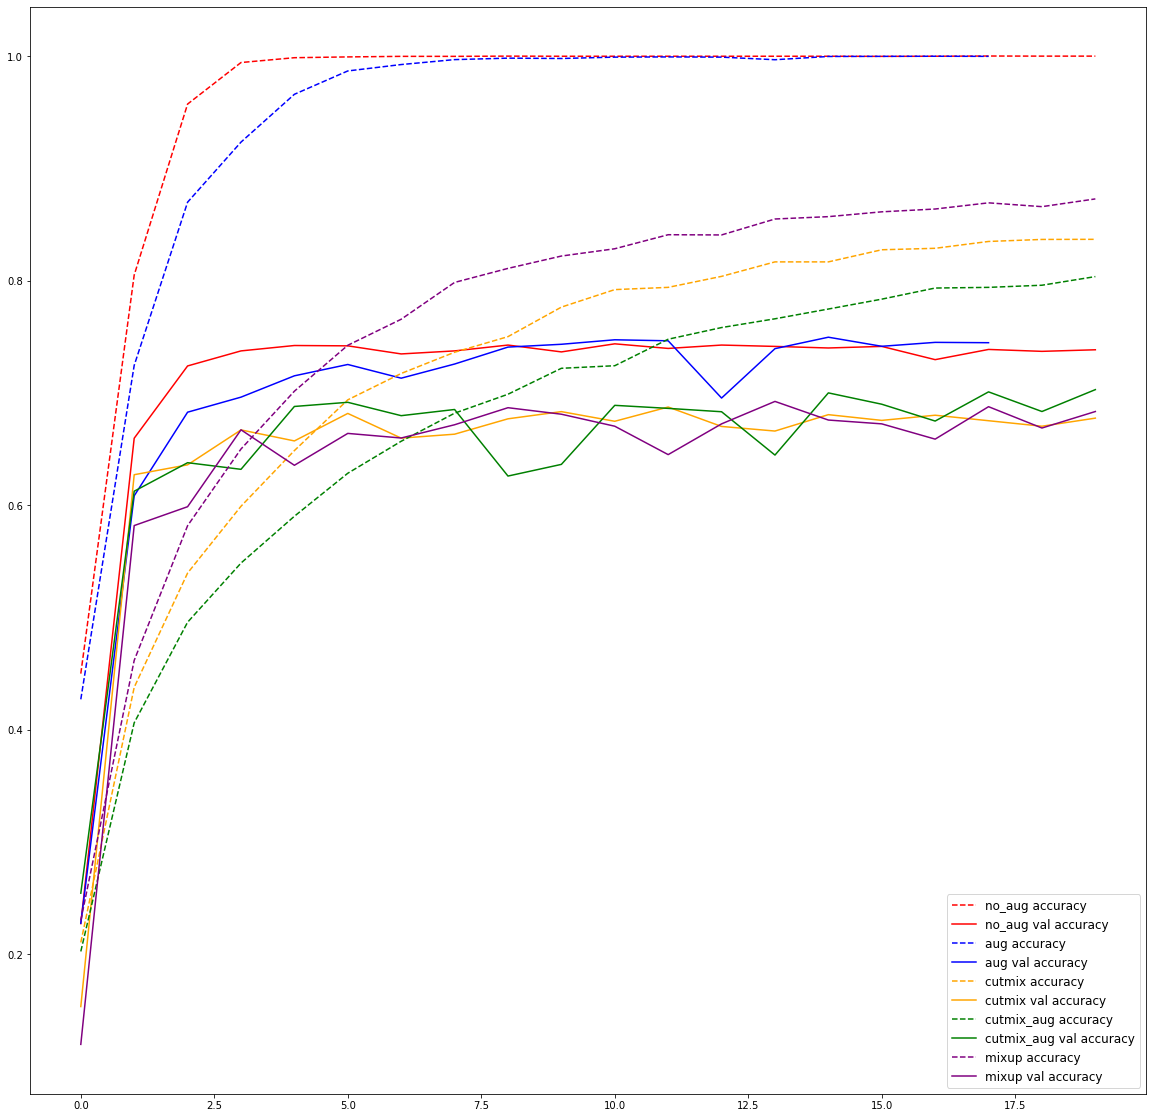

In [77]:
plt.figure(figsize=(20, 20))

colors = ['red', 'blue', 'orange', 'green', 'purple']

for history, condition, color in zip(total_history, conditions, colors):
    plt.plot(history['accuracy'], color=color, linestyle='--', label=f'{condition} accuracy')
    plt.plot(history['val_accuracy'], color=color, label=f'{condition} val accuracy')
    
plt.legend(fontsize='large')

성능이 no_aug일때가 가장 좋다... -> 왜?

--- 

더 추가적으로 결과를 뜯어봐야하는데 시간이 부족한게 아쉽다
